# Actor-Based Movie Communities and Their Relation to Genres, Ratings, and Plot Sentiment

**Research question:**  
How do communities in a movie similarity network (based on shared actors) relate to movie genres, user ratings, and plot sentiment?

This notebook contains the full data-cleaning, preprocessing, network-analysis, and community-analysis pipeline used in our final project.

It documents every step required to reproduce our results, including:

* Loading and preparing the IMDb dataset (actors, ratings, metadata)

* Merging IMDb with MovieLens metadata (genres, audience ratings, tags)

* Constructing the actor-based movie network

* Applying Louvain community detection

* Computing statistics that did not appear in the written report

* Evaluating genre distributions, rating distributions, and user-tag word clouds

The goal is to make the analysis transparent and reproducible, and to explain why each cleaning decision was made.

## 1. Data Loading and Parsing

We used the following data:
* MovieLens: There we had 4 csv files which had their own purpose. Links.csv was used to fetch from imdb with imdbid. Tags.csv was used to do the Wordclouds, ratings.csv was used for ratings distribution and movies.csv was used for genres.

* From Imdb we have top 10 actors for each movie and the plot synopsis.


In [1]:
# Import packages
import pandas as pd
import numpy as np
import re
from pathlib import Path
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
import networkx as nx
from collections import Counter
import seaborn as sns
import community as community_louvain 

from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer



In [2]:
# Load selected IMDb IDs
ids = pd.read_csv("movie_id.csv")
imdb_ids = set(ids["imdb_id"])

# Parse IMDb txt files
folder = Path("data/imdb_txt_synopsis_final")

def parse_movie_file(path):
    text = path.read_text(encoding="utf-8", errors="ignore")

    def extract(pattern, default=""):
        m = re.search(pattern, text)
        return m.group(1).strip() if m else default
    
    movieId = extract(r"movieId:\s*(\d+)")
    title = extract(r"title:\s*(.+)")
    url = extract(r"url:\s*(.+)")
    directors = extract(r"directors:\s*(.+)")
    actors_str = extract(r"actors:\s*(.+)")
    actors = [a.strip().lower() for a in actors_str.split(",")] if actors_str else []
    
    imdb_id = re.search(r"tt\d+", url).group(0)
    synopsis = text.split("synopsis:", 1)[-1].strip()
    
    return {
        "movieId": int(movieId),
        "imdb_id": imdb_id,
        "title": title,
        "directors": directors,
        "actors": actors,
        "synopsis": synopsis,
    }

# Parse into list
rows = []
for path in folder.glob("*.txt"):
    if path.stem in imdb_ids:
        rows.append(parse_movie_file(path))

df_movies = pd.DataFrame(rows)
print("Movies parsed:", len(df_movies))
df_movies.head()


Movies parsed: 3390


movieId    imdb_id                       title      directors  \
0     7541  tt0214388                   100 Girls  Michael Davis   
1     1367  tt0115433              101 Dalmatians  Stephen Herek   
2     6658  tt0078721                          10  Blake Edwards   
3     2572  tt0147800  10 Things I Hate About You     Gil Junger   
4     1203  tt0050083                12 Angry Men   Sidney Lumet   

                                              actors  \
0  [jonathan tucker, emmanuelle chriqui, james de...   
1  [glenn close, jeff daniels, joely richardson, ...   
2  [dudley moore, julie andrews, bo derek, robert...   
3  [heath ledger, julia stiles, joseph gordon-lev...   
4  [martin balsam, john fiedler, lee j. cobb, e.g...   

                                            synopsis  
0  After leaving a party at a women's dormitory (...  
1  Roger Dearly (Jeff Daniels) is an American vid...  
2  During a surprise 42nd birthday party for Geor...  
3  Cameron James (Joseph Gordon-Levitt), a new st...  
4  The story begins in a courtroom where an 18-ye...

## 2. Cleaning Actors, Genres, and Synopses

Here we clean the actors names, split genres into lists, lowercase everything, and remove movies
with fewer than 20 synopsis words so the sentiment analysis can be done properly in relation the the Louvrain communities. Also, to make our life easier it is better to have fewer nodes.


In [3]:
# Load MovieLens genres
movies_ml = pd.read_csv("Movielens/movies.csv")
movies_ml["movieId"] = movies_ml["movieId"].astype(int)

df_movies = df_movies.merge(movies_ml[["movieId", "genres"]], on="movieId", how="left")

# Convert genres to lists
df_movies["genres_list"] = df_movies["genres"].fillna("").str.lower().str.split("|")

# Clean synopsis
def clean_text(txt):
    return re.sub(r"[^a-zA-Z0-9\s]", " ", txt.lower())

df_movies["synopsis_clean"] = df_movies["synopsis"].fillna("").apply(clean_text)

# Count synopsis length
df_movies["synopsis_len"] = df_movies["synopsis_clean"].apply(lambda x: len(x.split()))

# Filter too-short synopses
df_movies = df_movies[df_movies["synopsis_len"] >= 20].reset_index(drop=True)
print("Movies after filtering:", len(df_movies))


Movies after filtering: 3370


### Add ratings from Movielens dataset

Since we are using the user ratings from ratings.csv, we need to add the average rating for each movie as an attribute

In [4]:
ratings = pd.read_csv("Movielens/ratings.csv")
avg_ratings = ratings.groupby("movieId")["rating"].mean().reset_index()
avg_ratings.columns = ["movieId", "rating"]

df_movies = df_movies.merge(avg_ratings, on="movieId", how="left")


## 3. Sentiment Analysis (LabMT)

Compute LabMT sentiment scores for each cleaned synopsis created above. The Labmt scores are from 1-9. We want to see further the statistics behind the sentiments of the 3370 movies. The lowest scoring movie has 4.7 and the highest 5.8 with 5.33 as the average. We clearly see that this confirms our suspicion of movie plots being too neutral in emotion and therefore all the movies are around the average.


In [5]:
# Load LabMT file
labmt = pd.read_csv(
    "labMT.txt",
    sep="\t",
    skiprows=2,
    engine="python",
    header=None
)

# Set column names manually
labmt.columns = ["word", "happiness_rank", "happiness_average",
                 "happiness_sd", "twitter_rank", "google_rank",
                 "nyt_rank", "lyrics_rank"]

# Keep only needed columns
labmt = labmt[["word", "happiness_average"]]
labmt["word"] = labmt["word"].astype(str)
labmt["happiness_average"] = pd.to_numeric(labmt["happiness_average"], errors="coerce")

# Dictionary for lookup
labmt_dict = dict(zip(labmt["word"], labmt["happiness_average"]))

def labmt_sentiment_from_clean(text):
    words = re.findall(r"[a-z]+", text)
    scores = [labmt_dict[w] for w in words if w in labmt_dict]
    return np.mean(scores) if scores else np.nan

df_movies["sentiment_labmt"] = df_movies["synopsis_clean"].apply(labmt_sentiment_from_clean)

df_movies["sentiment_labmt"].describe()


count    3370.000000
mean        5.337296
std         0.100879
min         4.756250
25%         5.265486
50%         5.331423
75%         5.407122
max         5.803509
Name: sentiment_labmt, dtype: float64

## 4. Building the Movie–Actor Bipartite Network

We first create a bipartite graph with movie and actor nodes. Movies are connected when they have the same actor. The bipartite network allows us to preserve the knowledge of which actor performed in which movie and allows the correct projection later.

In [6]:
B = nx.Graph()

# Add movies
for _, row in df_movies.iterrows():
    B.add_node(
        row["imdb_id"],
        bipartite="movie",
        title=row["title"],
        genres=row["genres_list"],
        rating=row["rating"],
        sentiment=row["sentiment_labmt"],
    )

# Add actors + edges
for _, row in df_movies.iterrows():
    movie = row["imdb_id"]
    for actor in row["actors"]:
        B.add_node(actor, bipartite="actor")
        B.add_edge(movie, actor)


## 5. Movie–Movie Similarity Network

Here we projected the bipartite graph into a movie-movie network. 
* Two movies are connected if they share at least one actor
* Edge weight equals number of shared actor.

The weighting is important because it distinguishes weak connections (1 actor) from stronger ones. This will hopefully give Louvain more structure and better clusters.

In [7]:
movie_nodes = [n for n, d in B.nodes(data=True) if d["bipartite"] == "movie"]

G = bipartite.weighted_projected_graph(B, movie_nodes)

print("Movies:", G.number_of_nodes())
print("Edges:", G.number_of_edges())


Movies: 3370
Edges: 59149


The nodes are 3370 as expected and the edges 59149, which means there are 59149 connections between all movies

## 6. Degree Distribution of the Movie Network


Here we want to see further the connections in the network. We both want to see the weighted and unweighted degree distribution.

In the original degree distribution the number of different movies a movie is directly connected to (has at least one shared actor with).

And then, for the weighted we have the sum of all the edge weights connected to that movie. So the total number of shared actors across all its neighboring movies.

It is difficult to see the proper different between the two on the graphs. But, it looks like the weighted distribution has movies with higher degree.

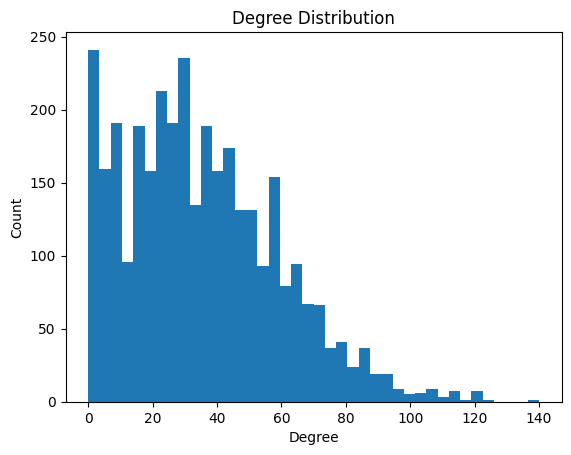

In [8]:
degrees = dict(G.degree())
plt.hist(degrees.values(), bins=40)
plt.xlabel("Degree")
plt.ylabel("Count")
plt.title("Degree Distribution")
plt.show()


Example strengths (first 10):
tt0214388 : 13
tt0115433 : 36
tt0078721 : 39
tt0147800 : 30
tt0050083 : 65
tt0114746 : 34
tt0053559 : 5
tt0337563 : 25
tt0179626 : 55
tt0068156 : 7


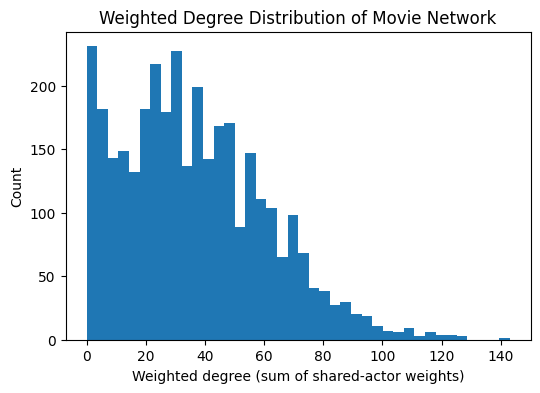

In [9]:
# Weighted degree (sum of edge weights) for each node
strengths = dict(G.degree(weight="weight"))

print("Example strengths (first 10):")
for n, s in list(strengths.items())[:10]:
    print(n, ":", s)

# Plot histogram of weighted degrees
plt.figure(figsize=(6,4))
plt.hist(strengths.values(), bins=40)
plt.xlabel("Weighted degree (sum of shared-actor weights)")
plt.ylabel("Count")
plt.title("Weighted Degree Distribution of Movie Network")
plt.show() 


## 7. Community Detection with Louvain

Next we want to create Louvain communities from the weighted movie-movie network. We know that Louvain works well with large networks from the rock network done earlier this semester. 


We commented out the text were the Louvain was created and saved.

In [10]:
#partition = community_louvain.best_partition(G, weight="weight", random_state=42)
#nx.set_node_attributes(G, partition, "community")

#df_movies["community"] = df_movies["imdb_id"].map(partition)

#Counter(df_movies["community"])


We can see that the Louvain generated a ton of communities. A lot of the communities only include 1 movie, which most likely dont share actors with other movies, and are probably a foreign movie. 

For the sake of the project, we decided to choose the top 4 communties to inspect further

Below we saved the Louvain Communities to a CSV file. We had to start over once and this was to keep the results, in case we had to add to the analysis

In [11]:
## df_movies[['imdb_id', 'community']].to_csv("final_louvain_partition.csv", index=False)
## print("Saved current communities to final_louvain_partition.csv")


### Loading the Louvain Communities

In [12]:
# Load saved Louvain communities instead of recomputing
louvain_df = pd.read_csv("final_louvain_partition.csv")

# Merge into df_movies
df_movies = df_movies.merge(louvain_df, on="imdb_id", how="left")

print("Loaded saved Louvain communities.")
df_movies[["imdb_id", "community"]].head()


Loaded saved Louvain communities.


imdb_id  community
0  tt0214388          0
1  tt0115433          1
2  tt0078721         10
3  tt0147800          3
4  tt0050083          4

### Plotting the top 4 Louvain Communities

We can see that the communities are somewhat well clustered. Especially the red and the grey one. But there are some overlaps between the communties, which is expected when working with a large network with only one "constraint" which is weighted shared actors.

Top 4 communities from CSV: [4, 3, 6, 1]


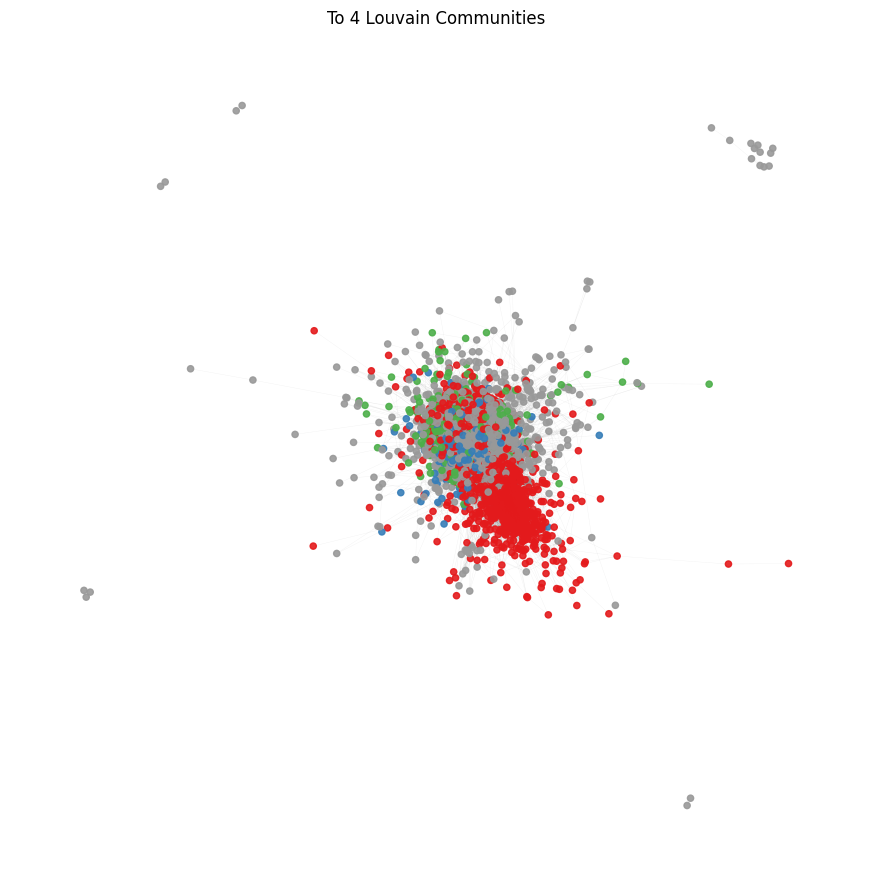

In [45]:
# dict: node (imdb_id) -> community
community_attr = dict(zip(louvain_df["imdb_id"], louvain_df["community"]))

# Identify the top 4 communities
counts = Counter(community_attr.values())
top4 = [c for c, _ in counts.most_common(4)]
print("Top 4 communities from CSV:", top4)

# Build color map for ALL nodes in G based on CSV communities 
#    top 4 communities get distinct colors, others = grey
color_map = {}
for node in G.nodes():
    comm = community_attr.get(node, None)
    if comm in top4:
        color_map[node] = top4.index(comm)  # 0..3
    else:
        color_map[node] = 10  # "other" → grey slot in colormap

# choosing threshold
deg_threshold = 1
core_nodes = [n for n, d in G.degree() if d >= deg_threshold]
G_core = G.subgraph(core_nodes).copy()

# Colors for core nodes in the same order as G_core.nodes()
node_colors = [color_map[n] for n in G_core.nodes()]

# plot
pos = nx.spring_layout(G_core, seed=42)  # layout on the core graph

plt.figure(figsize=(11, 11))

# Draw nodes
nx.draw_networkx_nodes(
    G_core,
    pos,
    node_size=20,
    node_color=node_colors,
    cmap=plt.cm.Set1,   # first 4 colors used for top4, others grey
    alpha=0.9
)

# Draw edges
nx.draw_networkx_edges(
    G_core,
    pos,
    width=0.3,
    alpha=0.05
)

plt.title("To 4 Louvain Communities")
plt.axis("off")
plt.show()


The communities are generally pretty well split up but not perfectly which is expected for a large network with degree of 1>. Also some movies may eppear visually far apart even though their structural connections place them in the same community. 

## 8. Community Profiles: Genres, Ratings, Sentiment

Now we want to investigate the biggest 4 communities better. For that we use the genre, ratings and sentiments attributes. Below we can see the top 4 communities where community 4 is by far the largest with 707 movies.


In [14]:
# Pick the 4 largest communities
community_sizes = df_movies["community"].value_counts()
top4_comms = community_sizes.head(4).index.tolist()

print("Top 4 communities:", top4_comms)
print(community_sizes.head(4))

df_top = df_movies[df_movies["community"].isin(top4_comms)].copy()


Top 4 communities: [4, 3, 6, 1]
community
4    707
3    494
6    348
1    300
Name: count, dtype: int64


### 8.1 Genres Distribution

Here we want to compare the genres between those 4 communties.

First we created a piechart It was decided to put all genres which had the ratio below 5% into a separate genre, "other"

Top 4 communities (by size): [4, 3, 6, 1]


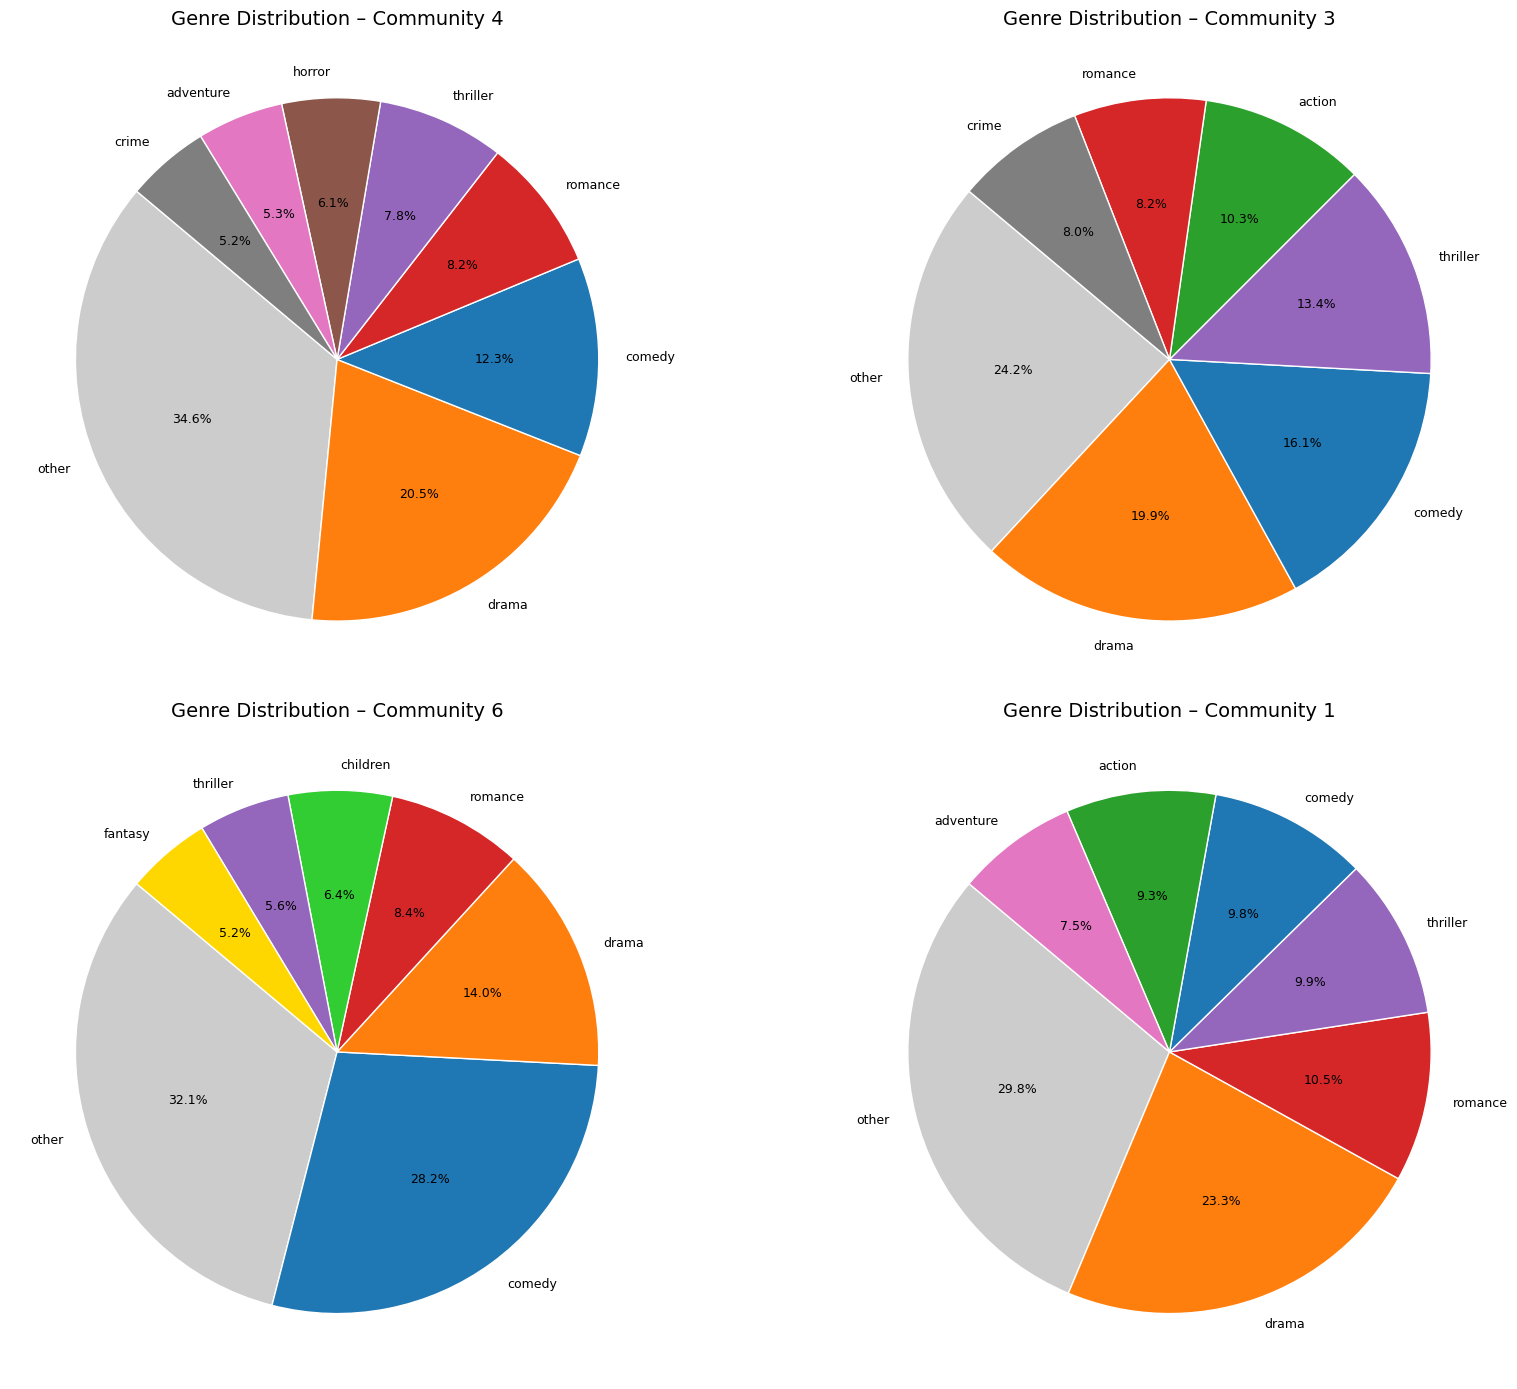

In [16]:
# normalize to lowercase
movies_exploded = df_movies.explode("genres_list").copy()

# Drop missing genres
movies_exploded = movies_exploded.dropna(subset=["genres_list"])

# Normalize
movies_exploded["genres_list"] = (
    movies_exploded["genres_list"]
    .astype(str)
    .str.strip()
    .str.lower()
)

# top 4 genres
top4_comms = (
    df_movies["community"]
    .value_counts()
    .head(4)
    .index
    .tolist()
)
print("Top 4 communities:", top4_comms)

# color mapping
genre_colors = {
    "comedy":    "#1f77b4",  # blue
    "drama":     "#ff7f0e",  # orange
    "action":    "#2ca02c",  # green
    "romance":   "#d62728",  # red
    "thriller":  "#9467bd",  # purple
    "horror":    "#8c564b",  # brown
    "adventure": "#e377c2",  # pink
    "crime":     "#7f7f7f",  # grey
    "sci-fi":    "#17becf",  # teal
    "animation": "#bcbd22",  # yellow-green,
    "fantasy":   "#FFD700",  # yellow
    "children":  "#32CD32",  # lime
}

default_color = "#cccccc" 

# 3. Plot pie charts for each of the top 4 communities
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.flatten()

for idx, comm_id in enumerate(top4_comms):
    ax = axes[idx]

    # Filter rows for this community
    subset = movies_exploded[movies_exploded["community"] == comm_id]

    if subset.empty:
        ax.set_title(f"Community {comm_id} (no data)")
        ax.axis("off")
        continue

    # Count genres
    genre_counts = subset["genres_list"].value_counts()

    # Merge genres <5% into "other"
    total = genre_counts.sum()
    proportions = genre_counts / total

    small_mask = proportions < 0.05
    big_counts = genre_counts[~small_mask].copy()
    other_count = genre_counts[small_mask].sum()

    if other_count > 0:
        big_counts["other"] = other_count

    # Sort descending for nicer order
    big_counts = big_counts.sort_values(ascending=False)

    labels = big_counts.index.tolist()
    sizes = big_counts.values

    # Get colors for each label
    colors = [
        genre_colors.get(g, default_color)
        for g in labels
    ]

    # Plot pie
    ax.pie(
        sizes,
        labels=labels,
        colors=colors,
        autopct="%1.1f%%",
        startangle=140,
        textprops={"fontsize": 9},
        wedgeprops={"edgecolor": "white"},
    )
    ax.set_title(f"Genre Distribution – Community {comm_id}", fontsize=14)

# If fewer than 4 communities
for j in range(len(top4_comms), 4):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


Proportions of genres for each community. Here we have the proportions, where we calculate total numbers of genres in a community divided by total number of genres in the community. Since most movies have more than 1 genre, the proportions end up being low

In [17]:
df_top.explode("genres_list") \
         .groupby("community")["genres_list"] \
         .value_counts(normalize=True) \
         .groupby(level=0).head(5)


community  genres_list
1          drama          0.232653
           romance        0.104762
           thriller       0.099320
           comedy         0.097959
           action         0.092517
3          drama          0.199160
           comedy         0.161345
           thriller       0.133613
           action         0.102521
           romance        0.081513
4          drama          0.205395
           comedy         0.122624
           romance        0.082158
           thriller       0.078479
           horror         0.060699
6          comedy         0.281782
           drama          0.140236
           romance        0.083879
           children       0.064220
           thriller       0.056356
Name: proportion, dtype: float64

Here we see the proportions of genres based on total movies in the community.

In [18]:
# Create a helper column
def genre_presence(row):
    return set(row["genres_list"])   # ensures duplicates won't matter

df_movies["genre_set"] = df_movies.apply(genre_presence, axis=1)

# Get all unique genres
all_genres = sorted({g for genre_list in df_movies["genres_list"] for g in genre_list})

results = {}

for comm in sorted(df_movies["community"].unique()):
    subset = df_movies[df_movies["community"] == comm]

    n_movies = len(subset)

    genre_counts = {
        genre: subset["genre_set"].apply(lambda s: genre in s).sum()
        for genre in all_genres
    }

    genre_proportions = {
        genre: count / n_movies
        for genre, count in genre_counts.items()
        if count > 0
    }

    # Sort descending
    results[comm] = dict(sorted(genre_proportions.items(), key=lambda x: -x[1]))

# Print nicely for the top 4 communities
top4 = [4, 3, 6, 1]

for comm in top4:
    print(f"\n=== Community {comm} ===")
    for genre, prop in list(results[comm].items())[:5]:
        print(f"{genre:10} {prop:.3f}")



=== Community 4 ===
drama      0.474
comedy     0.283
romance    0.190
thriller   0.181
horror     0.140

=== Community 3 ===
drama      0.480
comedy     0.389
thriller   0.322
action     0.247
romance    0.196

=== Community 6 ===
comedy     0.618
drama      0.307
romance    0.184
children   0.141
thriller   0.124

=== Community 1 ===
drama      0.570
romance    0.257
thriller   0.243
comedy     0.240
action     0.227


Drama is by far the most popular genre overall in these 4 communities

To explore this further we look at the distribution as a boxplot

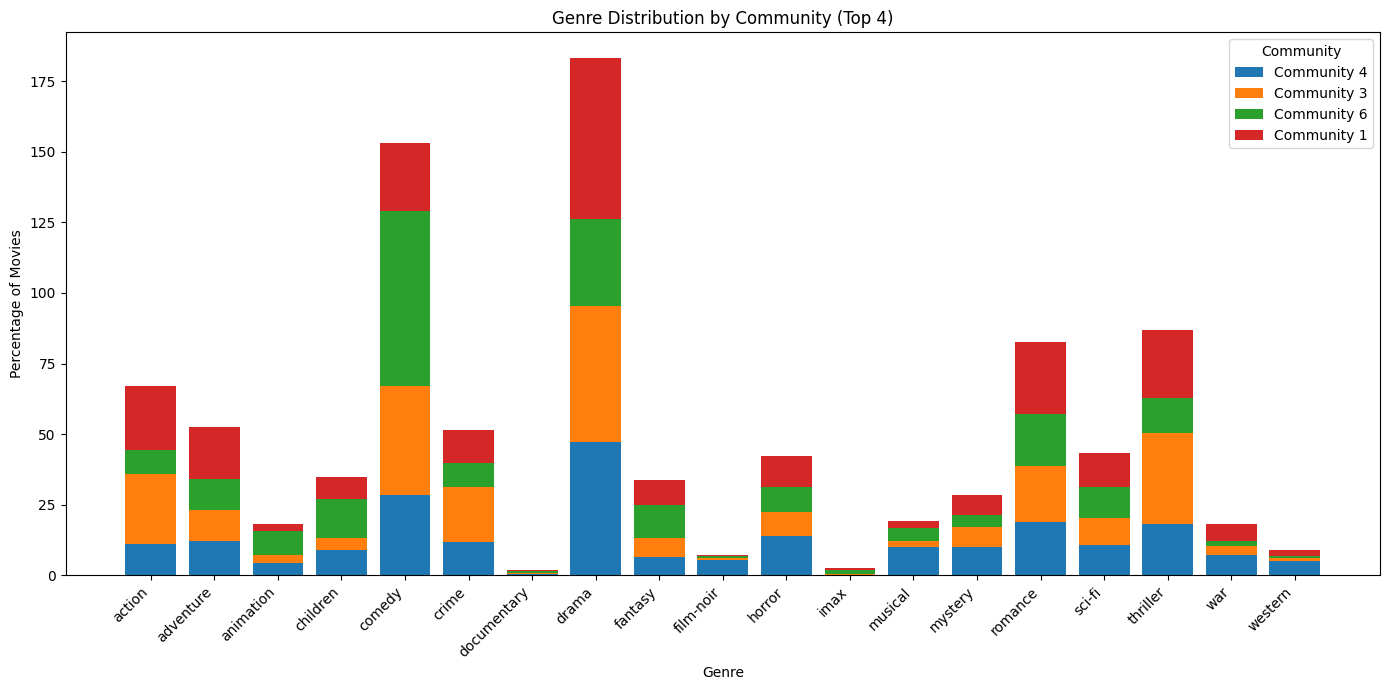

In [19]:
df_top = df_movies[df_movies["community"].isin(top4_comms)].copy()

# Explode genres and count unique movies per 
df_expl = df_top.explode("genres_list").dropna(subset=["genres_list"])

# Count how many movies in each community have each genre
genre_counts = (
    df_expl.groupby(["genres_list", "community"])["movieId"]
    .nunique()                      # unique movies, not rows
    .unstack("community", fill_value=0)
)

# Number of movies in each community
community_sizes = df_top.groupby("community")["movieId"].nunique()

# Convert to percantages
genre_pct = genre_counts.divide(community_sizes, axis=1) * 100

# sort genres alphabetically or by overall frequency
genre_pct = genre_pct.sort_index()

# Plot stacked bar chart for the 4 communities
plt.figure(figsize=(14, 7))

x = np.arange(len(genre_pct.index))
bottom = np.zeros(len(genre_pct))
communities_ordered = top4_comms

for comm in communities_ordered:
    vals = genre_pct[comm].values
    plt.bar(
        genre_pct.index,
        vals,
        bottom=bottom,
        label=f"Community {comm}",   # <-- use original community ID
    )
    bottom += vals

plt.ylabel("Percentage of Movies")
plt.xlabel("Genre")
plt.title("Genre Distribution by Community (Top 4)")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Community")
plt.tight_layout()
plt.show()


The two biggest genres are comedy and drama. While the other genres are much smaller. This does not come as a surprise, since most movies have a comedy or drama theme and actors within that structure usually get "stuck" in those roles.

### 8.2 Rating Distribution

The ratings are given from 1-5. We notice there is a bit of a different on the ratings. Community 4 has the highest with 3.51 as an average rating while community 6 has the lowest with 3.11 in average rating. This might indicate that community 4 has more "classics" than other communties.

In [20]:
ratings_top4 = (
    df_top.groupby("community")["rating"]
          .mean()
          .sort_values(ascending=False)
)

ratings_top4


community
4    3.509540
1    3.368336
3    3.230919
6    3.106926
Name: rating, dtype: float64

Top 4 communities: [4, 3, 6, 1]


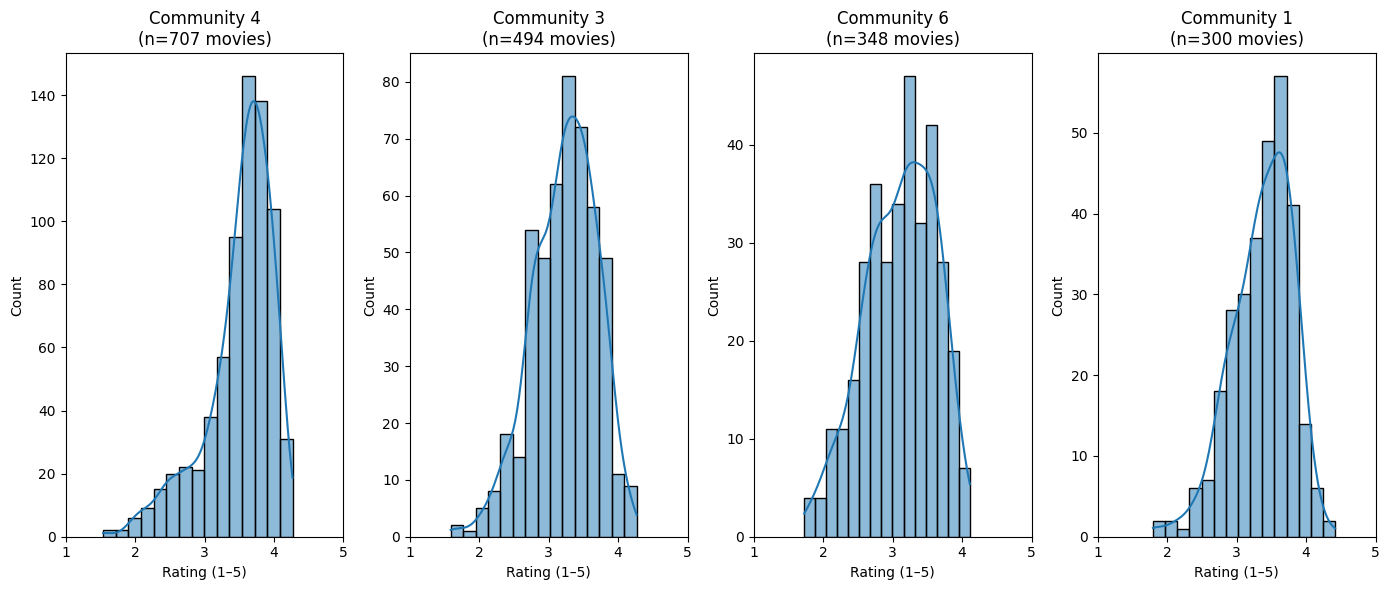

In [21]:

comm_counts = df_movies["community"].value_counts()
top4 = comm_counts.head(4).index.tolist()
print("Top 4 communities:", top4)

# Plot rating distributions
plt.figure(figsize=(14, 6))

for i, comm in enumerate(top4):
    plt.subplot(1, 4, i+1)
    sns.histplot(
        df_movies[df_movies["community"] == comm]["rating"],
        kde=True, bins=15
    )
    plt.title(f"Community {comm}\n(n={comm_counts[comm]} movies)")
    plt.xlabel("Rating (1–5)")
    plt.xlim(1, 5)
    plt.tight_layout()

plt.show()


Across the four largest communities the audience rating distributions are remarkably similar.
Each community is tightly centered around mid-to-high ratings (3–4 stars), suggesting that most films in the network—regardless of actor based groups tend to be evaluated positively by viewers.

### 8.3 Sentiment scores
Here we compare the sentiment scores in each community. This does not tell us anything, unfortunately. The neutral style of movie plots can't be detected using a basic sentiment analysis.

In [22]:
sentiment_top4 = (
    df_top.groupby("community")["sentiment_labmt"]
          .mean()
          .sort_values()
)

sentiment_top4


community
3    5.335195
4    5.335619
1    5.336814
6    5.370595
Name: sentiment_labmt, dtype: float64

## 9.WordClouds - Tags

We decided to use tags to create wordclouds. The synopsis is too neutral and therefore did not give us any valuable insigths, so using tags was decided. We cleaned the tags by lowercasing and using only for movies we have in the project.

In [23]:
# Load MovieLens tags file
tags = pd.read_csv("Movielens/tags.csv")  # adjust path if needed

# Basic cleaning of tag text
tags["tag_clean"] = (
    tags["tag"]
    .astype(str)
    .str.lower()
    .str.strip()
)

# Keep only tags for movies that are in df_movies (and thus have communities)
df_tags = tags.merge(
    df_movies[["movieId", "community"]],
    on="movieId",
    how="inner"
)

print("Total tag rows after merge:", len(df_tags))
df_tags.head()


Total tag rows after merge: 817370


userId  movieId            tag   timestamp      tag_clean  community
0      10      260   good vs evil  1430666558   good vs evil         10
1      10      260  Harrison Ford  1430666505  harrison ford         10
2      10      260         sci-fi  1430666538         sci-fi         10
3      14     1221      Al Pacino  1311600756      al pacino         21
4      14     1221          mafia  1311600746          mafia         21

Here we try to make the WordCloud better by removing words too rare. So we removed all tags that only were mentioned once.

In [25]:
from collections import Counter

tag_counts = Counter(df_tags["tag_clean"])

# Only keep tags that appear at least twice overall
MIN_TAG_FREQ = 2
df_tags = df_tags[df_tags["tag_clean"].map(tag_counts) >= MIN_TAG_FREQ].copy()

print("Rows after dropping rare tags:", len(df_tags))


Rows after dropping rare tags: 784257


In [26]:
def plot_tag_wordcloud_for_community(comm, max_words=100):
    """
    Build a wordcloud from tags of all movies in a given community.
    """
    subset = df_tags[df_tags["community"] == comm]["tag_clean"].dropna()
    if subset.empty:
        print(f"No tags for community {comm}")
        return
    
    text = " ".join(subset)

    wc = WordCloud(
        width=800,
        height=600,
        background_color="white",
        max_words=max_words
    ).generate(text)
    
    plt.figure(figsize=(10, 7))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Tag Wordcloud – Community {comm}", fontsize=16)
    plt.show()



=== Community 4 ===


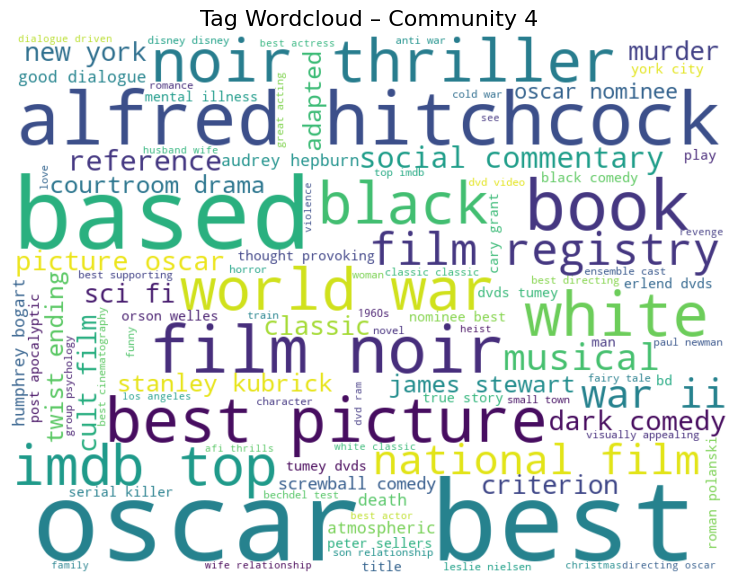


=== Community 3 ===


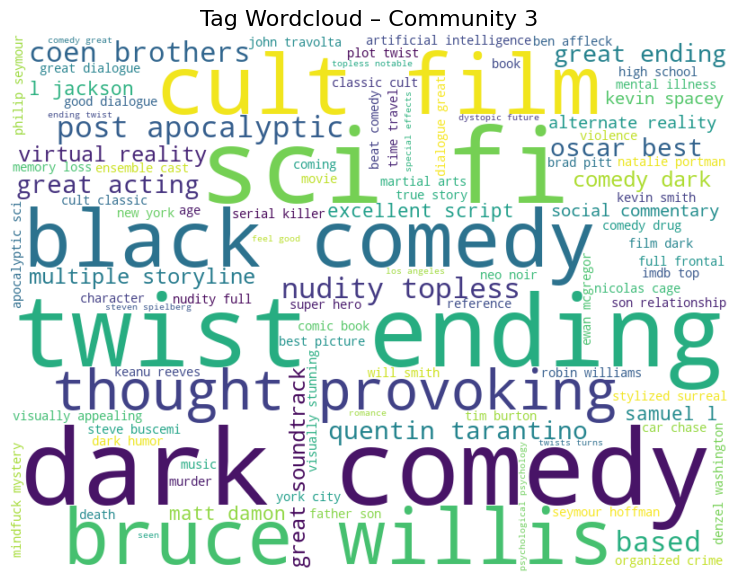


=== Community 6 ===


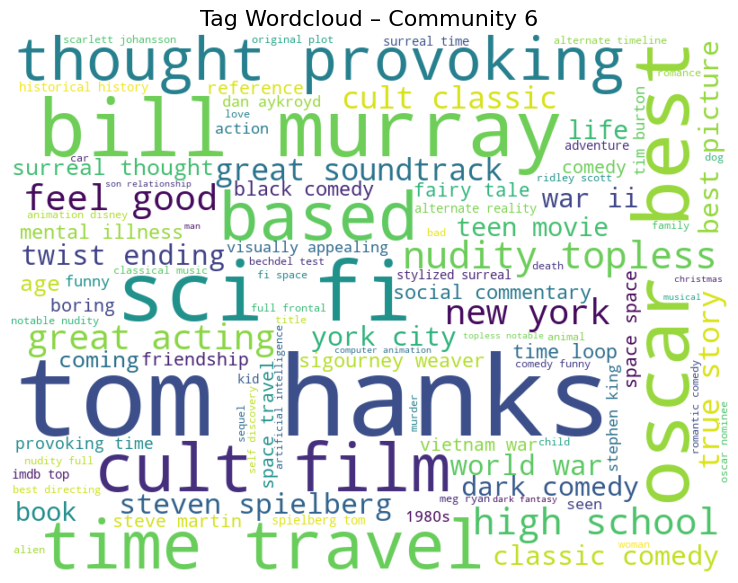


=== Community 1 ===


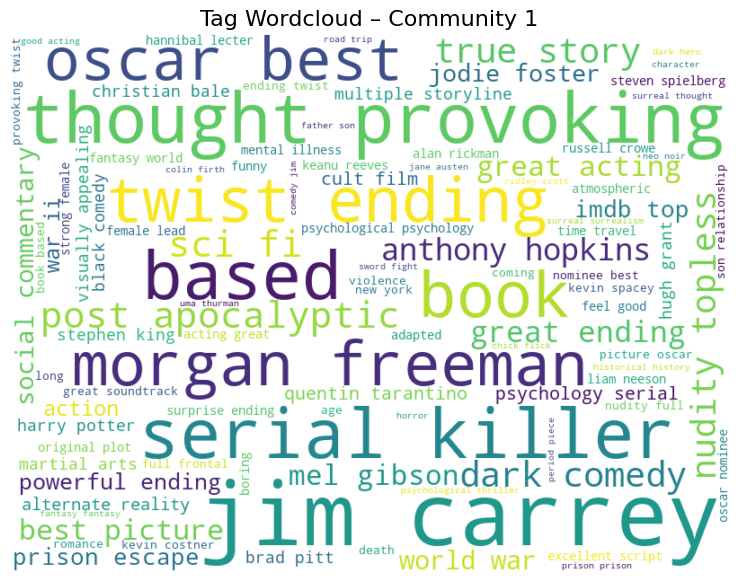

In [27]:
# Top 4 communities by movie count
top_communities = df_movies["community"].value_counts().index[:4]

for comm in top_communities:
    print(f"\n=== Community {comm} ===")
    plot_tag_wordcloud_for_community(comm)


### See top tags for each community

Here we inspected further the most frequent tags in the communities. As expected, from the ratings earlier, community 4 has the tags "classic" and "imdb top250" which explains the higher ratings. Community has "action," "dark comedy" and "twist ending" as the most frequent tags. Community 6 has "Tom Hanks" as its most frequent tag, so his movies must be dominant there and community 6 looks more different having tags like "psychology" and "thought provoking"

In [29]:
def top_tags_for_community(comm, k=15):
    subset = df_tags[df_tags["community"] == comm]["tag_clean"].dropna()
    counts = Counter(subset)
    return counts.most_common(k)

for comm in top_communities:
    print(f"\nTop tags for community {comm}:")
    for tag, c in top_tags_for_community(comm, k=15):
        print(f"  {tag}: {c}")



Top tags for community 4:
  classic: 1671
  atmospheric: 917
  black and white: 730
  alfred hitchcock: 681
  film noir: 532
  disney: 514
  bd-r: 488
  suspense: 477
  noir thriller: 467
  based on a book: 454
  murder: 431
  criterion: 411
  musical: 404
  imdb top 250: 402
  national film registry: 362

Top tags for community 3:
  dark comedy: 1627
  action: 1522
  twist ending: 1507
  sci-fi: 1457
  comedy: 1323
  cult film: 1019
  surreal: 983
  stylized: 960
  black comedy: 947
  quirky: 942
  funny: 889
  bruce willis: 884
  nonlinear: 870
  thought-provoking: 833
  psychology: 823

Top tags for community 6:
  tom hanks: 1238
  comedy: 1072
  funny: 757
  atmospheric: 679
  surreal: 622
  classic: 606
  sci-fi: 567
  bill murray: 531
  quirky: 479
  romance: 438
  bittersweet: 388
  time travel: 378
  cult film: 368
  drama: 354
  disney: 349

Top tags for community 1:
  psychology: 940
  thought-provoking: 820
  jim carrey: 794
  serial killer: 779
  based on a book: 701
  twi

## 10. NOT USED


### 10.1. Top Actors per Community - Not used

In our curiosity we looked at the top 10 connected actors in the communities. All the actor's name are big and well known and really doesn't give us a differential - But fun to see and confirms Tom Hanks dominance in community 6.

In [31]:
def top_actors_for_community(comm, k=10):
    subset = df_top[df_top["community"] == comm]
    actor_list = []
    for actors in subset["actors"]:
        actor_list.extend(actors)
    return Counter(actor_list).most_common(k)

for comm in top4_comms:
    print(f"\n=== Community {comm} (size={community_sizes[comm]}) ===")
    for actor, count in top_actors_for_community(comm, 10):
        print(f"  {actor}: {count} movies")



=== Community 4 (size=707) ===
  martin balsam: 16 movies
  james stewart: 16 movies
  cary grant: 16 movies
  humphrey bogart: 16 movies
  gregory peck: 16 movies
  peter sellers: 14 movies
  george kennedy: 14 movies
  henry fonda: 13 movies
  kirk douglas: 13 movies
  paul newman: 13 movies

=== Community 3 (size=494) ===
  bruce willis: 27 movies
  samuel l. jackson: 25 movies
  john travolta: 21 movies
  john goodman: 20 movies
  ben affleck: 18 movies
  nicolas cage: 17 movies
  keith david: 16 movies
  alec baldwin: 15 movies
  denzel washington: 15 movies
  john turturro: 14 movies

=== Community 6 (size=348) ===
  steve martin: 24 movies
  tom hanks: 24 movies
  dan aykroyd: 21 movies
  john candy: 18 movies
  bill murray: 17 movies
  william hurt: 16 movies
  chevy chase: 14 movies
  kevin kline: 12 movies
  marisa tomei: 10 movies
  michael mckean: 10 movies

=== Community 1 (size=300) ===
  mel gibson: 25 movies
  anthony hopkins: 21 movies
  morgan freeman: 17 movies
  li

### 10.2 Distribution of actor sharing weights

Most movie pairs share only one actor, reflecting the sparse structure of actor-based movie networks. A small number of edges with high weights represent franchises or tightly connected production groups. These strong ties help Louvain form meaningful communities, while weak ties remain appropriately separated.”

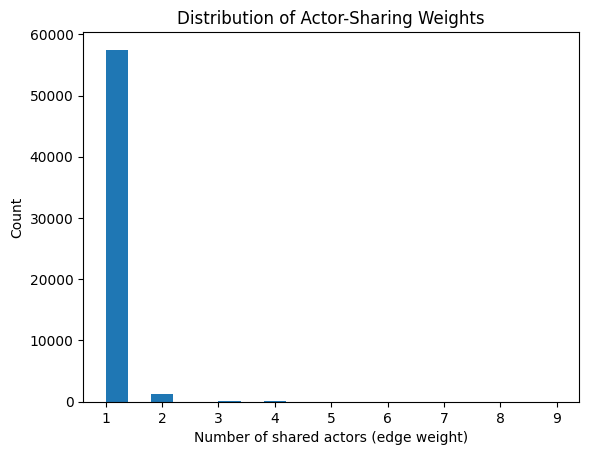

In [33]:


weights = [d["weight"] for _, _, d in G.edges(data=True)]
plt.hist(weights, bins=20)
plt.xlabel("Number of shared actors (edge weight)")
plt.ylabel("Count")
plt.title("Distribution of Actor-Sharing Weights")
plt.show()


In [34]:
sorted(G.edges(data=True), key=lambda x: x[2]["weight"], reverse=True)[:10]


[('tt0101862', 'tt0113041', {'weight': 9}),
 ('tt0095882', 'tt0098105', {'weight': 9}),
 ('tt0084522', 'tt0086129', {'weight': 9}),
 ('tt0303714', 'tt0337579', {'weight': 8}),
 ('tt0072979', 'tt0069089', {'weight': 8}),
 ('tt0087332', 'tt0097428', {'weight': 8}),
 ('tt0099785', 'tt0104431', {'weight': 8}),
 ('tt0088170', 'tt0084726', {'weight': 8}),
 ('tt0092007', 'tt0102975', {'weight': 8}),
 ('tt0076759', 'tt0080684', {'weight': 8})]

### 10.4 TF-IDF wordcloud for top 4 communities (Using synopsis)

In [35]:
# Prepare documents: one big text per community
community_docs = (
    df_movies.groupby("community")["synopsis_clean"]
             .apply(lambda x: " ".join(x))
)

vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words="english",
)
tfidf_matrix = vectorizer.fit_transform(community_docs)

feature_names = vectorizer.get_feature_names_out()


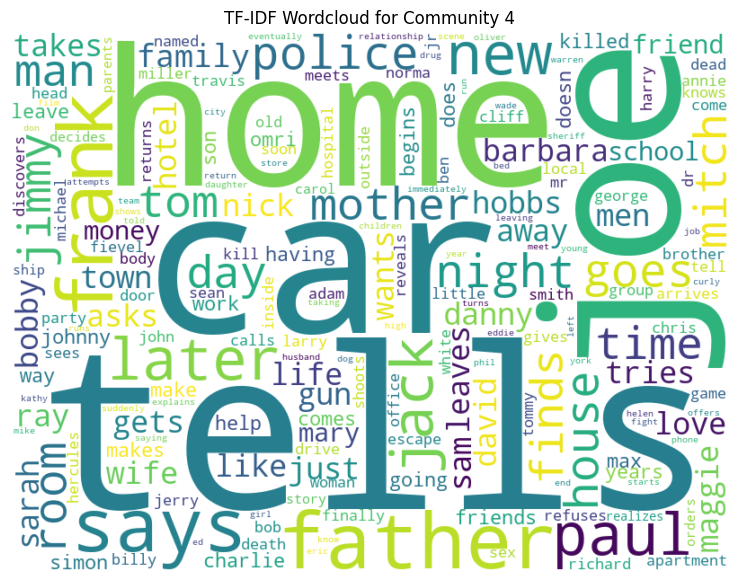

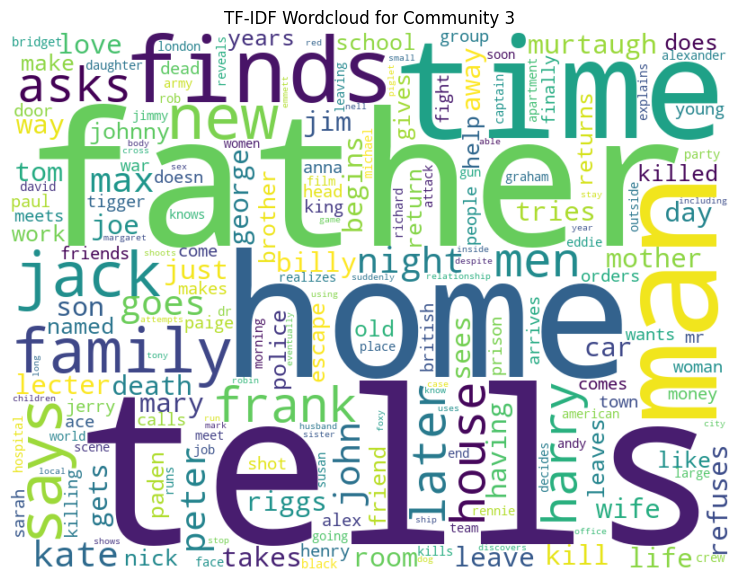

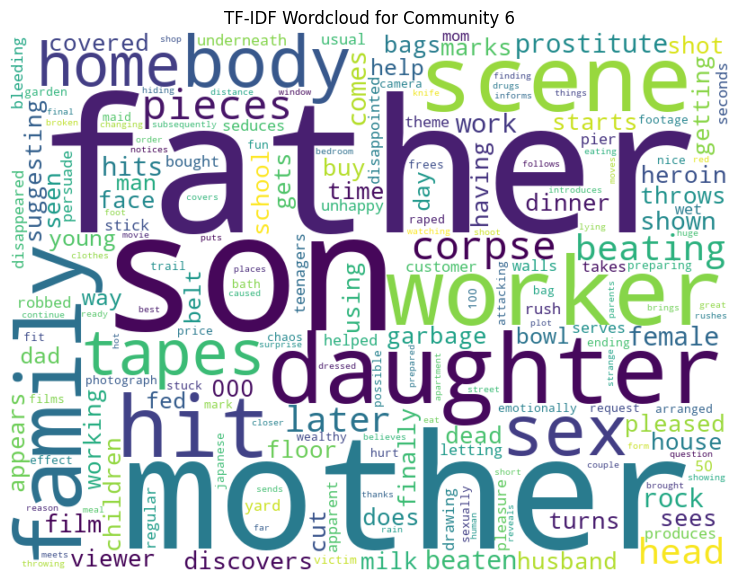

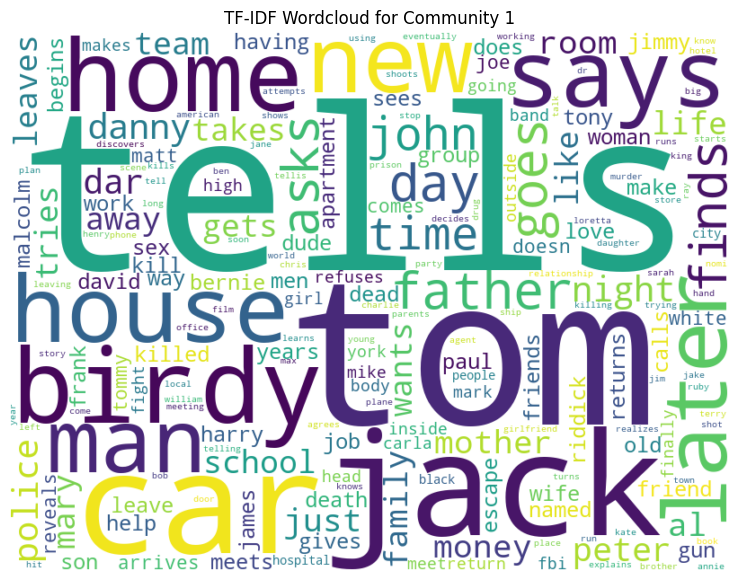

In [36]:
def plot_tfidf_wordcloud(comm_index, comm_id):
    # extract TF-IDF row for this community
    row = tfidf_matrix[comm_index].toarray().flatten()
    
    # make dictionary: word → tf-idf score
    weights = {feature_names[i]: row[i] for i in range(len(feature_names))}
    
    wc = WordCloud(
        width=800,
        height=600,
        background_color="white",
        max_words=200
    ).generate_from_frequencies(weights)
    
    plt.figure(figsize=(10, 7))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"TF-IDF Wordcloud for Community {comm_id}")
    plt.show()

# Plot only for top 4 communities
top4 = df_movies["community"].value_counts().index[:4]

for idx, comm in enumerate(top4):
    plot_tfidf_wordcloud(idx, comm)


When looking at the results above we straight away saw that the words were too common. And at that point we realized that a mistake was made to look at the synopsis. It would have been possible to skip using the synopsis plots and do an analysis with much, much more movies for a better insight

### 10.5 Wordcloud TF-IDF (Using review tags)

In [42]:
top_communities = df_movies["community"].value_counts().index[:4].tolist()
print("Top 4 communities:", top_communities)

# Keep only tags for the top communities
df_tags_top = df_tags[df_tags["community"].isin(top_communities)].copy()

# For each community, collect a list of tags
docs_tokens = (
    df_tags_top
    .groupby("community")["tag_clean"]
    .apply(list)
)
docs_tokens = docs_tokens.reindex(top_communities)

vectorizer = TfidfVectorizer(
    tokenizer=lambda x: x,      # x is already a list of tokens
    preprocessor=lambda x: x,
    token_pattern=None,         
    min_df=2,                   # tag must appear in at least 2 communities
    max_df=0.9                  # drop tags that appear in almost all communities
)

tfidf_matrix = vectorizer.fit_transform(docs_tokens)
feature_names = vectorizer.get_feature_names_out()


Top 4 communities: [4, 3, 6, 1]


In [43]:
def plot_tfidf_wordcloud_for_community(comm, top_n=80):
    """
    Plot a TF-IDF-based wordcloud for a given community ID.
    """
    if comm not in top_communities:
        print(f"Community {comm} is not in top_communities {top_communities}")
        return
    
    # Row index for this community in the TF-IDF matrix
    row_idx = top_communities.index(comm)
    row = tfidf_matrix[row_idx].toarray().ravel()

    # Indices of top_n highest TF-IDF tags
    top_idx = row.argsort()[::-1][:top_n]
    freqs = {feature_names[j]: row[j] for j in top_idx if row[j] > 0}

    if not freqs:
        print(f"No TF-IDF terms for community {comm}")
        return

    wc = WordCloud(
        width=800,
        height=600,
        background_color="white",
        max_words=top_n,
        colormap="viridis"   # change if you like
    ).generate_from_frequencies(freqs)

    plt.figure(figsize=(10, 7))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"TF-IDF Tag Wordcloud – Community {comm}", fontsize=16)
    plt.show()



=== Community 4 ===


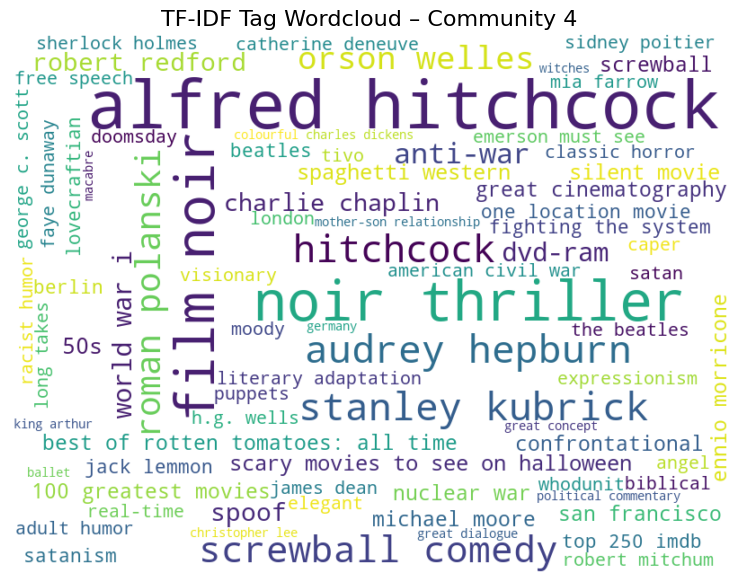


=== Community 3 ===


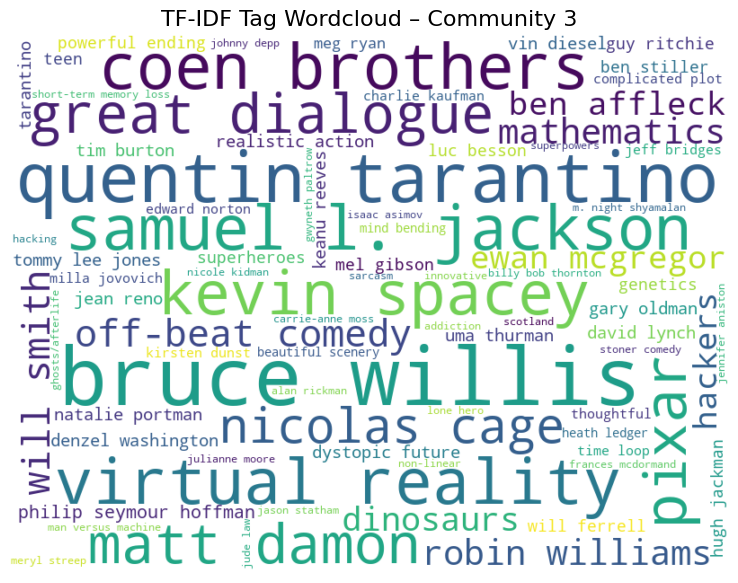


=== Community 6 ===


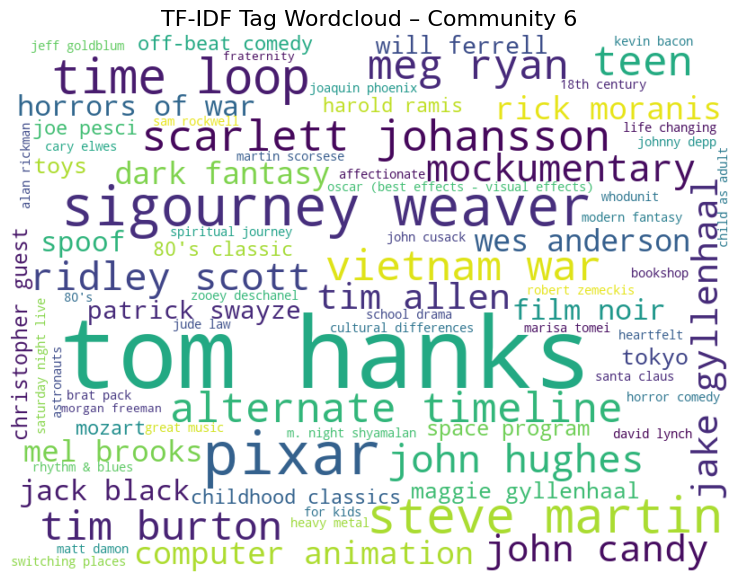


=== Community 1 ===


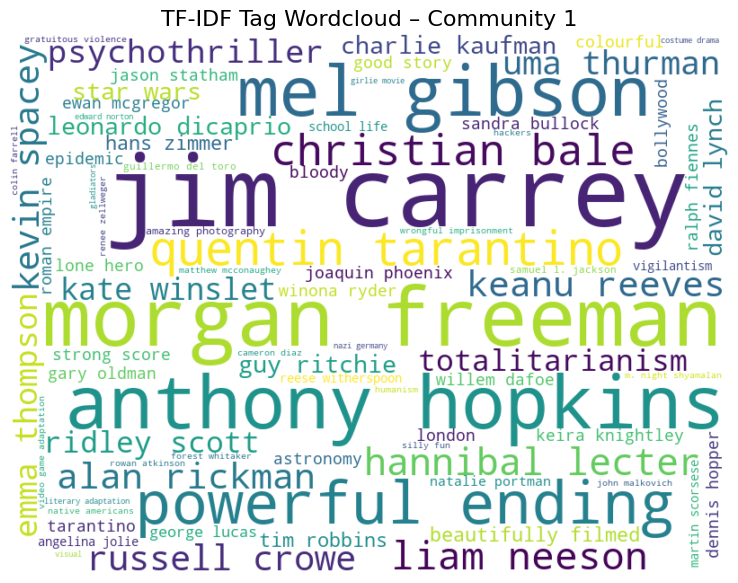

In [44]:
for comm in top_communities:
    print(f"\n=== Community {comm} ===")
    plot_tfidf_wordcloud_for_community(comm, top_n=80)


Above, the IDF wordclouds can be seen for the top 4 communities. The most common are actors names. Which does not help us with our analysis so it was decded to use the frequency Wordcloud